## Task5: Putting it All Together and formulating the QNLP model <br>
In this task, a new class is defined called "ClassificationModel" that is a subclass of the NumpyModel <br>
The main idea was to implement the forward method that evalautes a pair of circuits and compare between them <br>
No change is made in the loss or accuracy evaluation methods <br>

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
import numpy as np

BATCH_SIZE = 50
EPOCHS = 120
SEED = 2

In [3]:
def read_data(filename):
    labels, sentences1, sentences2 = [], [], []
    with open(filename) as f:
        for line in f:
            split_list = line.split(",")
            t = int(split_list[2])
            labels.append(t)
            sentences1.append(split_list[0])
            sentences2.append(split_list[1])
    return labels, sentences1, sentences2

all_labels, all_sentences1, all_sentences2 = read_data('MC1.TXT')
all_data = list(zip(all_sentences1[0:80], all_sentences2[0:80]))

train_labels, train_data1, train_data2 = all_labels[0: 80], all_sentences1[0: 80], all_sentences2[0: 80]
test_labels, test_data1, test_data2 = all_labels[80: 100], all_sentences1[80: 100], all_sentences2[80: 100]
test_data =  list(zip(all_sentences1[80:100], all_sentences2[80:100]))


In [4]:
from lambeq import BobcatParser

parser = BobcatParser(verbose='text')

raw_train_sentences1_diagrams = parser.sentences2diagrams(train_data1)
raw_test_sentences1_diagrams = parser.sentences2diagrams(test_data1)
raw_train_sentences2_diagrams = parser.sentences2diagrams(train_data2)
raw_test_sentences2_diagrams = parser.sentences2diagrams(test_data2)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


In [5]:
from lambeq import remove_cups

train_s1_diagrams = [remove_cups(diagram) for diagram in raw_train_sentences1_diagrams]

test_s1_diagrams = [remove_cups(diagram) for diagram in raw_test_sentences1_diagrams]

train_s2_diagrams = [remove_cups(diagram) for diagram in raw_train_sentences2_diagrams]

test_s2_diagrams = [remove_cups(diagram) for diagram in raw_test_sentences2_diagrams]

In [6]:
from lambeq import AtomicType, IQPAnsatz

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=2, n_single_qubit_params=3)

train_s1_circuits = [ansatz(diagram) for diagram in train_s1_diagrams]

test_s1_circuits = [ansatz(diagram) for diagram in test_s1_diagrams]

train_s2_circuits = [ansatz(diagram) for diagram in train_s2_diagrams]

test_s2_circuits = [ansatz(diagram) for diagram in test_s2_diagrams]

train_circuits = train_s1_circuits + train_s2_circuits
test_circuits =  test_s1_circuits + test_s2_circuits
all_circuits_lst = train_circuits + test_circuits
all_train_data = list(zip((list(zip(train_s1_circuits, train_s2_circuits))), train_labels))
all_test_data =  list(zip(list(zip(test_s1_circuits, test_s2_circuits)), test_labels))
all_data = all_train_data + all_test_data

In [7]:
from pytket.circuit.display import render_circuit_jupyter

tket_circuit = train_circuits[17].to_tk()

render_circuit_jupyter(tket_circuit)

In [14]:
from lambeq import NumpyModel, Model
def cos_sim_2d(x, y):
        norm_x = x / np.linalg.norm(x, axis=1, keepdims=True)
        norm_y = y / np.linalg.norm(y, axis=1, keepdims=True)
        return np.matmul(norm_x, norm_y.T)
class ClassificationModel(NumpyModel): 
    right_prediction = 0
    wrong_prediction = 0
    def forward(self, Mytuple):
        a = np.array(Mytuple)
        y_hat = []
        output1 = NumpyModel.get_diagram_output(self, diagrams=a[:, 0])
        output2 = NumpyModel.get_diagram_output(self, diagrams=a[:, 1])
        
        similarity_matrix = cos_sim_2d(output1, output2)
        y_hat = np.diagonal(similarity_matrix)
        return np.array(y_hat)


In [15]:

#Model.initialize_weights()
train_circuits2 = list(zip(train_s1_circuits , train_s2_circuits))
test_circuits2 = list(zip(test_s1_circuits , test_s2_circuits))
all_circuits = train_circuits2 + test_circuits2
sentence1_circuits= [ seq[0] for seq in all_circuits]
sentence2_circuits= [ seq[1] for seq in all_circuits]
all_circuits = sentence1_circuits + sentence2_circuits
model = ClassificationModel.from_diagrams(all_circuits_lst, use_jit=True)


In [16]:
import numpy
epsilon=numpy.finfo('float').eps
loss = lambda y_hat, y: -np.sum(y * np.log(y_hat + epsilon)) / len(y)  # binary cross-entropy lossةخيثم
acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting

In [17]:
from lambeq import QuantumTrainer, SPSAOptimizer

trainer = QuantumTrainer(
    model,
    epochs=EPOCHS,
    loss_function=loss,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    verbose = 'text',
    seed=0
)

In [18]:
from lambeq import Dataset

train_dataset = Dataset(
            train_circuits2,
            train_labels,
            batch_size=BATCH_SIZE)

val_dataset = Dataset(test_circuits2, test_labels, shuffle=False)


In [19]:
trainer.fit(train_dataset, val_dataset, logging_step=12)

Epoch 1:    train/loss: 0.0765   valid/loss: 0.0578   train/acc: 0.2750   valid/acc: 0.2500
Epoch 12:   train/loss: 0.0453   valid/loss: 0.0344   train/acc: 0.2750   valid/acc: 0.2250
Epoch 24:   train/loss: 0.0531   valid/loss: 0.0250   train/acc: 0.2750   valid/acc: 0.2250
Epoch 36:   train/loss: 0.0546   valid/loss: 0.0136   train/acc: 0.2750   valid/acc: 0.2250
Epoch 48:   train/loss: 0.0411   valid/loss: 0.0088   train/acc: 0.2750   valid/acc: 0.2250
Epoch 60:   train/loss: 0.0334   valid/loss: 0.0078   train/acc: 0.2750   valid/acc: 0.2250
Epoch 72:   train/loss: 0.0312   valid/loss: 0.0062   train/acc: 0.2750   valid/acc: 0.2250
Epoch 84:   train/loss: 0.0285   valid/loss: 0.0061   train/acc: 0.2750   valid/acc: 0.2250
Epoch 96:   train/loss: 0.0325   valid/loss: 0.0061   train/acc: 0.2750   valid/acc: 0.2250
Epoch 108:  train/loss: 0.0242   valid/loss: 0.0063   train/acc: 0.2750   valid/acc: 0.2250
Epoch 120:  train/loss: 0.0244   valid/loss: 0.0068   train/acc: 0.2750   valid/

Test accuracy: 0.225


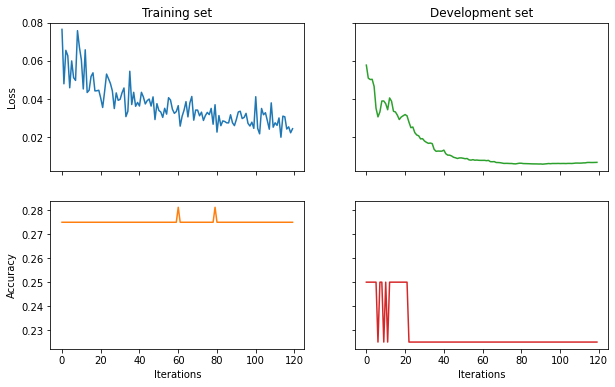

In [20]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(trainer.train_results['acc'], color=next(colours))
ax_tr.plot(trainer.val_costs, color=next(colours))
ax_br.plot(trainer.val_results['acc'], color=next(colours))

test_acc = acc(model(test_circuits2), test_labels)
print('Test accuracy:', test_acc)